# Environment Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
config = {
    'domain': 'spouse',
    'postgres': False,
    'parallelism': 1,
    'db_name': 'babble_spouse_demo',
    'babbler_candidate_split': 1,
    'babbler_label_split': 1,
    'supervision': 'generative',
    'disc_model_class': 'logreg',
    'gen_model_search_space': 1,
    'disc_model_search_space': 1,
}

In [3]:
# Get DB connection string and add to globals
# NOTE: $SNORKELDB must be set before any snorkel imports
import os

default_db_name = 'babble_' + config['domain'] + ('_debug' if config.get('debug', False) else '')
DB_NAME = config.get('db_name', default_db_name)
if 'postgres' in config and config['postgres']:
    DB_TYPE = 'postgres'
else:
    DB_TYPE = 'sqlite'
    DB_NAME += '.db'
DB_ADDR = "localhost:{0}".format(config['db_port']) if 'db_port' in config else ""
os.environ['SNORKELDB'] = '{0}://{1}/{2}'.format(DB_TYPE, DB_ADDR, DB_NAME)
print("$SNORKELDB = {0}".format(os.environ['SNORKELDB']))

$SNORKELDB = sqlite:///babble_spouse_demo.db


In [4]:
from snorkel import SnorkelSession
session = SnorkelSession()

# Resolve config conflicts (nb_config > local_config > global_config)
from snorkel.contrib.babble.pipelines import merge_configs
config = merge_configs(config)

Overwriting disc_model_search_space=10 to disc_model_search_space=1
Overwriting domain=None to domain=spouse
Overwriting print_freq=1 to print_freq=5
Overwriting disc_model_search_space=10 to disc_model_search_space=1
Overwriting init_class_prior=0 to init_class_prior=-1.15
Overwriting reg_param=0.1 to reg_param=0.5
Overwriting decay=0.95 to decay=0.99
Overwriting gen_model_search_space=10 to gen_model_search_space=1
Overwriting disc_model_class=lstm to disc_model_class=logreg


In [5]:
from snorkel.models import candidate_subclass
from tutorials.babble.spouse import SpousePipeline

Spouse = candidate_subclass('Spouse', ['person1', 'person2'])
candidate_class = Spouse
pipe = SpousePipeline(session, Spouse, config)

### Initialization

In [6]:
# %time pipe.parse()

In [7]:
# %time pipe.extract()

In [8]:
# %time pipe.load_gold()

In [9]:
# %time pipe.featurize()

### Pre-load Explanations (10) + User Lists (4)

In [10]:
from snorkel.contrib.babble import BabbleStream
bs = BabbleStream(session, candidate_class=Spouse, balanced=True, shuffled=True, seed=1234)

In [11]:
from tutorials.babble.spouse.spouse_examples import get_explanations, get_user_lists

spouse_explanations = get_explanations()
spouse_user_lists = get_user_lists()
# spouse_explanations = []
# spouse_user_lists = {}

In [12]:
bs.preload(explanations=spouse_explanations, user_lists=spouse_user_lists)

Created grammar with 590 rules
Flushing all parses from previous explanation set.
All previously uncommitted parses have been flushed.
9 explanation(s) out of 9 were parseable.
23 parse(s) generated from 9 explanation(s).
11 parse(s) remain (12 parse(s) removed by DuplicateSemanticsFilter).
Note: 11 LFs did not have candidates and therefore could not be filtered.
11 parse(s) remain (0 parse(s) removed by ConsistencyFilter).
### Applying labeling functions to split 1
[========================================] 100%

### Done in 18.3s.

11 parse(s) remain (0 parse(s) removed by UniformSignatureFilter: (0 None, 0 All)).
9 parse(s) remain (2 parse(s) removed by DuplicateSignatureFilter).
Added 9 parse(s) from 9 explanations to set. (Total # parses = 9)
### Applying labeling functions to split 0
[========================================] 100%

Stored 64547 triples for split 0. Now shape is (22195, 9).
### Done in 95.7s.

### Applying labeling functions to split 2
[===========================

# Start Demo:

### View user_lists

In [13]:
user_lists = bs.user_lists
for alias, values in user_lists.items():
    if len(values) <= 10:
        print("{}:\n {}\n".format(alias, values))
    else:
        print("{}:\n {}...\n".format(alias, list(values)[:10]))

known_spouses:
 [('Eleanor Powell', 'Glenn Ford'), ('Andronikos Doukas', 'Maria of Bulgaria'), ('Marjorie Rambeau', 'Willard Mack'), ('Margo St. James', 'Paul Avery'), ('Joan of England', 'William II the Good'), ('Maiko Jeong Shun Lee', 'The Viscount Rothermere'), ('Heinrich von Coudenhove-Kalergi', 'Mitsuko Aoyama'), ('Kiran Nadar', 'Shiv Nadar ( )'), ('Cecilia Mnsdotter Eka', 'Erik Johansson Vasa'), ('Bonne of Bohemia', 'John the Good')]...

spouse:
 ['spouse', 'wife', 'husband', 'ex-wife', 'ex-husband']

family:
 ['father', 'father', 'mother', 'sister', 'sisters', 'brother', 'brothers', 'son', 'sons', 'daughter']...

friend:
 ['boyfriend', 'girlfriend', 'boss', 'employee', 'secretary', 'co-worker']

last_names:
 [('Merezhkovsky', 'Gippius'), ('Deakin', 'Simkins'), ('Mattson', 'Roth'), ('Kenyatta', 'Kenyatta'), ('Neville', 'Howard'), ('Nelson', 'Mason'), ('Troy', 'McNamara'), ('Vuuren', 'Vuuren'), ('Menthe', 'Brunswick-Lneburg'), ('Tyson', 'Davis')]...



Optionally add another user_list.

In [14]:
ALIAS = None    # e.g., 'marriage_words'
VALUES = []    # e.g., ['engaged', 'betrothed', 'proposed']

if ALIAS:
    bs.add_user_lists({ALIAS: VALUES})

### View a candidate

In [15]:
c = bs.next()
from snorkel.viewer import SentenceNgramViewer
sv = SentenceNgramViewer([c], session, n_per_page=1, height=max(len(c.get_parent().words)*2, 80))
sv

<IPython.core.display.Javascript object>

### Give an explanation

(See MTurk instructions for examples)

In [16]:
LABEL = True
CONDITION = ("there are no people between X and Y and 'husband' is immediately to the left of Y")
# CONDITION = ("'husband' is immediately to the left of Y") # it's faster

# LABEL = True
# CONDITION = "X and Y are less than 10 words apart and 'wife' is between them"

# LABEL = False
# CONDITION = "'syndrome' occurs within three words to the right of arg 2"

# LABEL = False
# CONDITION = "')' is between X and Y"

With the user input and the current candidate, we make an Explanation object.

In [17]:
from snorkel.contrib.babble import Explanation
explanation = Explanation(CONDITION, LABEL, candidate=c)

### Parse and view labeling stats

In [18]:
%time parse_list, filtered_parses, conf_matrix_list, stats_list = bs.apply(explanation)

Flushing all parses from previous explanation set.
All previously uncommitted parses have been flushed.
1 explanation(s) out of 1 were parseable.
2 parse(s) generated from 1 explanation(s).
1 parse(s) remain (1 parse(s) removed by DuplicateSemanticsFilter).
1 parse(s) remain (0 parse(s) removed by ConsistencyFilter).
### Applying labeling functions to split 1
[========================================] 100%

### Done in 0.3s.

1 parse(s) remain (0 parse(s) removed by UniformSignatureFilter: (0 None, 0 All)).
1 parse(s) remain (0 parse(s) removed by DuplicateSignatureFilter).
CPU times: user 662 ms, sys: 23.2 ms, total: 686 ms
Wall time: 669 ms


In [19]:
PARSE_IDX = 0
parse = parse_list[PARSE_IDX]
conf_matrix = conf_matrix_list[PARSE_IDX]
stats = stats_list[PARSE_IDX]

print("Parse {}:\n{}\n".format(PARSE_IDX, bs.semparser.grammar.translate(parse.semantics)))
print(stats.accuracy)
print(stats.class_coverage)
print(stats.coverage)

Parse 0:
return 1 if (count([x for x in between([arg1,arg2]) if re.match(r'PERSON', x.ner_tags)]).(= 0) and 'husband'.in(text(exactly 1 words to the left of arg2))) else 0

Accuracy: 80.77% (21/26)
ClassCoverage: 13.27% (26/196)
Coverage: 0.93% (26/2796)


In [20]:
bs.filtered_analysis(filtered_parses)


Filter DuplicateSemanticsFilter removed 1 parse(s):

#0 Filtered parse:
Explanation (source):
Explanation("Explanation0: True, there are no people between X and Y and 'husband' is immediately to the left of Y")

Parse (pseudocode):
return 1 if (count([x for x in between([arg1,arg2]) if re.match(r'PERSON', x.ner_tags)]).(= 0) and 'husband'.in(text(exactly 1 words to the left of arg2))) else 0

Reason:
Collision with parse from this explanation:
Explanation("Explanation0: True, there are no people between X and Y and 'husband' is immediately to the left of Y")


In [21]:
parse.semantics

('.root',
 ('.label',
  ('.bool', True),
  ('.and',
   ('.call',
    ('.eq', ('.int', 0)),
    ('.count',
     ('.filter',
      ('.between', ('.list', ('.arg', ('.int', 1)), ('.arg', ('.int', 2)))),
      'ner_tags',
      'PERSON'))),
   ('.call',
    ('.in',
     ('.extract_text',
      ('.left',
       ('.arg', ('.int', 2)),
       ('.string', '.eq'),
       ('.int', 1),
       ('.string', 'words')))),
    ('.string', 'husband')))))

### View labeled candidates

Select the subset of labeled candidates you would like to view.

In [22]:
SUBSET = 'correct' # Must be one of ['correct', 'incorrect', 'abstained']

subset = getattr(conf_matrix_list[0], SUBSET)
def candidate_generator(subset):
    for c in subset: 
        yield c
subset_generator = candidate_generator(subset)

In [23]:
from snorkel.viewer import SentenceNgramViewer
c = subset_generator.next()
sv = SentenceNgramViewer([c], session, n_per_page=3, height=max(len(c.get_parent().words)*2, 80))
sv

<IPython.core.display.Javascript object>

### Commit parses

If you are satisfied with the given parses, commit them.

In [24]:
bs.commit()

Added 1 parse(s) from 1 explanations to set. (Total # parses = 10)


In [25]:
%time bs.label_split(0)

### Applying labeling functions to split 0
[========================================] 100%

Stored 279 triples for split 0. Now shape is (22195, 10).
### Done in 38.0s.

CPU times: user 37.3 s, sys: 1.03 s, total: 38.4 s
Wall time: 38.3 s


In [26]:
%time bs.label_split(2)

### Applying labeling functions to split 2
[========================================] 100%

Stored 49 triples for split 2. Now shape is (2697, 10).
### Done in 4.7s.

CPU times: user 4.59 s, sys: 178 ms, total: 4.77 s
Wall time: 4.72 s


In [27]:
# This is here for illustration purposes.
# No need to call this every time; it will be called by set_babbler_matrices.
%time bs.get_label_matrix(0)

CPU times: user 1.04 s, sys: 39.4 ms, total: 1.08 s
Wall time: 1.08 s


<22195x10 sparse matrix of type '<type 'numpy.int64'>'
	with 64826 stored elements in Compressed Sparse Row format>

### View global stats

In [32]:
bs.get_global_coverage()

GlobalCoverage: 97.39% (2723/2796)

In [33]:
bs.get_lf_stats()

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.
LF_spouse_to_left_0,0,0.070100,0.069385,0.069385,86,110,0,0,0.438776
LF_no_spouse_in_sentence_0,1,0.822604,0.795780,0.000715,0,0,75,2225,0.967391
LF_family_between_0,2,0.967454,0.945279,0.069742,0,0,192,2513,0.929020
LF_family_to_left_0,3,0.110873,0.110873,0.006080,0,0,5,305,0.983871
LF_friend_between_0,4,0.016810,0.016810,0.001431,0,0,6,41,0.872340
LF_distant_0,5,0.001073,0.001073,0.001073,2,1,0,0,0.666667
LF_too_far_apart_0,6,0.536123,0.536123,0.042203,0,0,75,1424,0.949967
LF_third_wheel_0,7,0.363376,0.363376,0.025393,0,0,39,977,0.961614
LF_identical_args_0,8,0.056509,0.056509,0.001073,0,0,1,157,0.993671
Explanation0_0,9,0.009299,0.009299,0.009299,21,5,0,0,0.807692


In [34]:
bs.get_parses()

["return 1 if any(map((at least one of the following): ([in(text(no more than 2 words to the left of arg1)),in(text(no more than 2 words to the left of arg2))]), $'spouse'$)) else 0",
 "return -1 if sum(map(in(text(the sentence)), $'spouse'$)).(= 0) else 0",
 "return -1 if count([x for x in between([arg1,arg2]) if re.match(r'\\w+\\S*', x.words)]).(>= 1) else 0",
 "return -1 if any(map((at least one of the following): ([in(text(no more than 3 words to the left of arg1)),in(text(no more than 3 words to the left of arg2))]), $'family'$)) else 0",
 "return -1 if any(map(in(text(between([arg1,arg2]))), $'friend'$)) else 0",
 "return 1 if any(map(in($'known_spouses'$), [tuple([text(arg1),text(arg2)]),tuple([text(arg2),text(arg1)])])) else 0",
 'return -1 if count(between([arg1,arg2])).(> 10) else 0',
 "return -1 if count([x for x in between([arg1,arg2]) if re.match(r'PERSON', x.ner_tags)]).(>= 1) else 0",
 'return -1 if text(arg1).(= text(arg2)) else 0',
 "return 1 if (count([x for x in betw

In [35]:
bs.get_lfs()

[<function snorkel.contrib.babble.grammar.grammar.LF_spouse_to_left_0>,
 <function snorkel.contrib.babble.grammar.grammar.LF_no_spouse_in_sentence_0>,
 <function snorkel.contrib.babble.grammar.grammar.LF_family_between_0>,
 <function snorkel.contrib.babble.grammar.grammar.LF_family_to_left_0>,
 <function snorkel.contrib.babble.grammar.grammar.LF_friend_between_0>,
 <function snorkel.contrib.babble.grammar.grammar.LF_distant_0>,
 <function snorkel.contrib.babble.grammar.grammar.LF_too_far_apart_0>,
 <function snorkel.contrib.babble.grammar.grammar.LF_third_wheel_0>,
 <function snorkel.contrib.babble.grammar.grammar.LF_identical_args_0>,
 <function snorkel.contrib.babble.grammar.grammar.Explanation0_0>]

In [36]:
bs.get_explanations()

[Explanation("LF_spouse_to_left: True, there is a spouse word within two words to the left of arg 1 or arg 2"),
 Explanation("LF_no_spouse_in_sentence: False, there are no spouse words in the sentence"),
 Explanation("LF_family_between: False, there is a family word between arg 1 and arg 2"),
 Explanation("LF_family_to_left: False, there is a family word within three words to the left of arg 1 or arg 2"),
 Explanation("LF_friend_between: False, there is an friend word between arg 1 and arg 2"),
 Explanation("LF_distant: True, either the pair of arg 1 and arg 2 or the pair arg 2 and arg 1 is in known_spouses"),
 Explanation("LF_too_far_apart: False, the number of words between arg 1 and arg 2 is larger than 10"),
 Explanation("LF_third_wheel: False, there is a person between arg 1 and arg 2"),
 Explanation("LF_identical_args: False, arg 1 is identical to arg 2"),
 Explanation("Explanation0: True, there are no people between X and Y and 'husband' is immediately to the left of Y")]

## REPEAT (go back to "START DEMO")

When you have entered all of the explanations that you would like to, run these final cells.

In [37]:
# NOTE: Don't use this. Instead, incrementally label using bs.label_split() after each commit.
# pipe.lfs = bs.get_lfs()
# %time pipe.label()

In [38]:
%time pipe.set_babbler_matrices(bs) # Pulls out and saves label matrices from babbler.

CPU times: user 689 ms, sys: 7.97 ms, total: 697 ms
Wall time: 697 ms


Using L_train: <22195x10 sparse matrix of type '<type 'numpy.int64'>'
	with 64826 stored elements in Compressed Sparse Row format>
Using L_gold_train: <22195x1 sparse matrix of type '<type 'numpy.int64'>'
	with 22195 stored elements in Compressed Sparse Row format>
Positive Fraction: 7.0%

Using L_dev: <2796x10 sparse matrix of type '<type 'numpy.float64'>'
	with 8260 stored elements in Compressed Sparse Row format>
Using L_gold_dev: <2796x1 sparse matrix of type '<type 'numpy.int64'>'
	with 2796 stored elements in Compressed Sparse Row format>
Positive Fraction: 7.0%

Using L_test: <2697x10 sparse matrix of type '<type 'numpy.int64'>'
	with 7961 stored elements in Compressed Sparse Row format>
Using L_gold_test: <2697x1 sparse matrix of type '<type 'numpy.int64'>'
	with 2697 stored elements in Compressed Sparse Row format>
Positive Fraction: 8.3%

Skipping grid search.
Inferred cardinality: 2
[GenerativeModel] Model saved as <generative_spouse>.

Gen. model (DP) score on dev set (b=0.

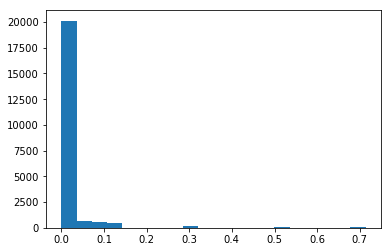

Saved 22195 marginals
CPU times: user 1min 9s, sys: 344 ms, total: 1min 10s
Wall time: 1min 10s


In [39]:
%time pipe.supervise()

(22195,)


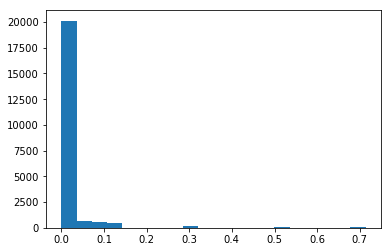

### [7.1] Begin training discriminative model
Skipping grid search.
[SparseLogisticRegression] Training model
[SparseLogisticRegression] n_train=172  #epochs=20  batch size=128
[SparseLogisticRegression] Epoch 0 (0.03s)	Average loss=0.762900	Dev F1=12.25
[SparseLogisticRegression] Epoch 5 (0.21s)	Average loss=0.247161	Dev F1=4.86
[SparseLogisticRegression] Epoch 10 (0.40s)	Average loss=0.214481	Dev F1=0.00
[SparseLogisticRegression] Epoch 15 (0.58s)	Average loss=0.184292	Dev F1=0.00
[SparseLogisticRegression] Epoch 19 (0.75s)	Average loss=0.197957	Dev F1=0.00
[SparseLogisticRegression] Training done (0.87s)
[SparseLogisticRegression] Model saved as <discriminative_spouse>
### Done in 2.2s.

### [7.2] Evaluate generative model (opt_b=0.1)
### Done in 1.1s.

### [7.3] Evaluate discriminative model (opt_b=0.1)
### Done in 0.1s.

      F1 Score  Precision    Recall
Disc  0.196747   0.119025  0.566964
Gen   0.468571   0.650794  0.366071
CPU times: user 48.5 s, sys: 1.49 s, total: 50 s
Wall 

In [40]:
%time pipe.classify()

Note: in general, we expect Disc to do better than Gen. However, with small sample sizes, major class imbalance, or lack of grid search, those may flip.

### Notes